In [ ]:
# Import and load data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load dataset
df = pd.read_csv(r"..\data\raw\marketing_campaign.csv", encoding='ISO-8859-1', sep="\t") 

print("Initial shape:", df.shape)
print(df.head(3))
print(df.info())

Initial shape: (2240, 29)
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  

In [2]:
# -------------------------------
#  Data Cleaning
# -------------------------------

# Drop constant columns (like Z_Revenue or Z_CostContact)
df = df.drop(columns=[col for col in df.columns if df[col].nunique() == 1])  

print("After dropping duplicates and constant columns:", df.shape)

After dropping duplicates and constant columns: (2240, 27)


In [3]:
# Impute missing income with median
df['Income'] = df['Income'].fillna(df['Income'].median())  

# Check missing values
df.isnull().sum()

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Response               0
dtype: int64

In [4]:
# Convert to datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')  

# Calculate age
current_year = pd.Timestamp.today().year
df['Age'] = current_year - df['Year_Birth']

# Quick check
df[['Dt_Customer','Year_Birth','Age']].head(5)

,Dt_Customer,Year_Birth,Age
0,2012-09-04,1957,69
1,2014-03-08,1954,72
2,2013-08-21,1965,61
3,2014-02-10,1984,42
4,2014-01-19,1981,45


In [5]:
# Remove outliers

# Age outliers using IQR
Q1_age = df['Age'].quantile(0.25)
Q3_age = df['Age'].quantile(0.75)
IQR_age = Q3_age - Q1_age
lower_age = Q1_age - 1.5 * IQR_age
upper_age = Q3_age + 1.5 * IQR_age
df = df[(df['Age'] >= lower_age) & (df['Age'] <= upper_age)]

# Income outliers using IQR
Q1_income = df['Income'].quantile(0.25)
Q3_income = df['Income'].quantile(0.75)
IQR_income = Q3_income - Q1_income
lower_income = Q1_income - 1.5 * IQR_income
upper_income = Q3_income + 1.5 * IQR_income
df = df[(df['Income'] >= lower_income) & (df['Income'] <= upper_income)]

print("After outlier removal:", df.shape)

After outlier removal: (2229, 28)


In [6]:
# Standardize categorical text
df['Education'] = df['Education'].str.strip().str.lower()  # Remove extra spaces + standardize casing
df['Marital_Status'] = df['Marital_Status'].str.strip().str.lower()

print("Unique Education:", df['Education'].unique())
print("Unique Marital_Status:", df['Marital_Status'].unique())

Unique Education: <StringArray>
['graduation', 'phd', 'master', 'basic', '2n cycle']
Length: 5, dtype: str
Unique Marital_Status: <StringArray>
['single', 'together', 'married', 'divorced', 'widow', 'alone', 'absurd',
 'yolo']
Length: 8, dtype: str


In [7]:
# -------------------------------
#  Feature Engineering
# -------------------------------

df['Customer_Tenure_Days'] = (pd.Timestamp.today() - df['Dt_Customer']).dt.days  # Tenure in days

# Spending columns
spend_cols = ['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']

# Log-transform skewed spending
df[spend_cols] = df[spend_cols].apply(lambda x: np.log1p(x))  # Reduce skew

# Total spending across products
df['Total_Spending'] = df[spend_cols].sum(axis=1)

# Total purchases across channels
purchase_cols = ['NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases']
df['Total_Purchases'] = df[purchase_cols].sum(axis=1)

In [8]:
# -------------------------------
#  New Features
# -------------------------------

# Total children at home
df['Children_at_home'] = df['Kidhome'] + df['Teenhome']

# Consolidate Marital_Status into Living_With
df["Living_With"] = df["Marital_Status"].replace({
    "married":"Partner", "together":"Partner",
    "absurd":"Alone", "widow":"Alone", "yolo":"Alone",
    "divorced":"Alone", "single":"Alone", "alone":"Alone"
})

# Consolidate Education categories
df['Education'] = df['Education'].replace({
    'basic':'Undergraduate',
    '2n cycle':'Undergraduate',
    'graduation':'Graduate',
    'master':'Postgraduate',
    'phd':'PhD',
    })

# Map Living_With to numeric for family size calculation
df['Living_With_Num'] = df['Living_With'].map({"Alone":1,"Partner":2})
df['Living_With_Num'] = df['Living_With_Num'].fillna(1)  # Any unexpected ==> Alone

# Total family members
df['Family_Size'] = df['Living_With_Num'] + df['Children_at_home']

In [9]:
# -------------------------------
#  DROP NOT NEEDED / REDUNDANT / INTERMEDIATE COLUMNS
# -------------------------------

df = df.drop(columns=[
    'Kidhome',            # Replaced by Children_at_home
    'Teenhome',           # Replaced by Children_at_home
    'Marital_Status',     # Replaced by Living_With
    'Living_With_Num',    # Temporary column for Family_Size
    'Dt_Customer',        # Replaced by Customer_Tenure_Days
     'ID',                # Not needed
     'Year_Birth'         # Replaced by Age
])

=== Data Info ===
<class 'pandas.DataFrame'>
Index: 2229 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Education             2229 non-null   str    
 1   Income                2229 non-null   float64
 2   Recency               2229 non-null   int64  
 3   MntWines              2229 non-null   float64
 4   MntFruits             2229 non-null   float64
 5   MntMeatProducts       2229 non-null   float64
 6   MntFishProducts       2229 non-null   float64
 7   MntSweetProducts      2229 non-null   float64
 8   MntGoldProds          2229 non-null   float64
 9   NumDealsPurchases     2229 non-null   int64  
 10  NumWebPurchases       2229 non-null   int64  
 11  NumCatalogPurchases   2229 non-null   int64  
 12  NumStorePurchases     2229 non-null   int64  
 13  NumWebVisitsMonth     2229 non-null   int64  
 14  AcceptedCmp3          2229 non-null   int64  
 15  AcceptedCmp4       

,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,AcceptedCmp2,Complain,Response,Age,Customer_Tenure_Days,Total_Spending,Total_Purchases,Children_at_home,Living_With,Family_Size
0,Graduate,58138.0,58,6.455199,4.488636,6.304449,5.153292,4.488636,4.488636,3,...,0,0,1,69,4924,31.378848,25,0,Alone,1
1,Graduate,46344.0,38,2.484907,0.693147,1.945910,1.098612,0.693147,1.945910,2,...,0,0,0,72,4374,8.861634,6,2,Alone,3
2,Graduate,71613.0,26,6.056784,3.912023,4.852030,4.718499,3.091042,3.761200,1,...,0,0,0,61,4573,26.391579,21,0,Partner,2
3,Graduate,26646.0,26,2.484907,1.609438,3.044522,2.397895,1.386294,1.791759,2,...,0,0,0,42,4400,12.714816,8,1,Partner,3
4,PhD,58293.0,94,5.159055,3.784190,4.779123,3.850148,3.332205,2.772589,5,...,0,0,0,45,4422,23.677309,19,1,Partner,3



=== Numeric Summary ===


,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Customer_Tenure_Days,Total_Spending,Total_Purchases,Children_at_home,Family_Size
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,...,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000
mean,51619.504262,49.106326,4.682330,2.242687,4.128059,2.538682,2.245432,3.127559,2.319874,4.100045,...,0.064603,0.013459,0.008973,0.149843,57.111261,4614.777479,18.964748,14.869000,0.951996,2.596231
std,20601.216248,28.946476,1.800136,1.570153,1.554425,1.658498,1.594124,1.284325,1.895252,2.775461,...,0.245879,0.115255,0.094319,0.356998,11.707430,202.248700,7.821410,7.622187,0.751976,0.907432
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,30.000000,4261.000000,2.772589,0.000000,0.000000,1.000000
25%,35416.000000,24.000000,3.218876,1.098612,2.833213,1.386294,0.693147,2.302585,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,49.000000,4442.000000,12.200557,8.000000,0.000000,2.000000
50%,51381.500000,49.000000,5.176150,2.197225,4.219508,2.564949,2.197225,3.218876,2.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,56.000000,4617.000000,18.779791,15.000000,1.000000,3.000000
75%,68118.000000,74.000000,6.226537,3.526361,5.446737,3.931826,3.555348,4.043051,3.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,67.000000,4790.000000,26.136129,21.000000,1.000000,3.000000
max,113734.000000,99.000000,7.309212,5.298317,7.453562,5.560682,5.575949,5.894403,15.000000,27.000000,...,1.000000,1.000000,1.000000,1.000000,86.000000,4960.000000,33.697922,43.000000,3.000000,5.000000



=== Categorical Value Counts ===

Education:
Education
Graduate         1124
PhD               481
Postgraduate      369
Undergraduate     255
Name: count, dtype: int64

Living_With:
Living_With
Partner    1436
Alone       793
Name: count, dtype: int64


C:\Users\ibjio\AppData\Local\Temp\ipykernel_16720\23842606.py:18: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = df.select_dtypes(include='object').columns.tolist()


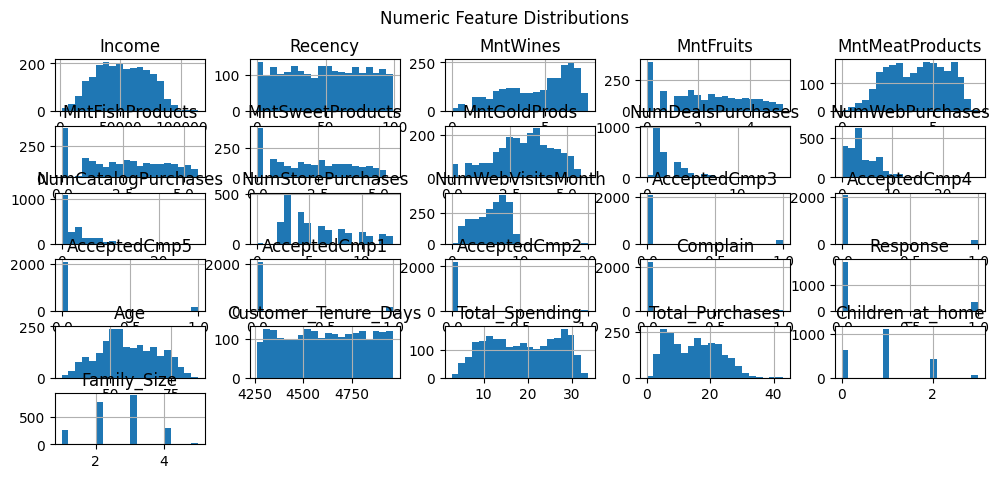

In [13]:
# -------------------------------
#  Check Preprocessed Data
# -------------------------------
import matplotlib.pyplot as plt

# Basic info and top rows
print("=== Data Info ===")
df.info()

print("\n=== First 5 Rows ===")
display(df.head())

# Numeric summary
print("\n=== Numeric Summary ===")
display(df.describe())

# Categorical summary
cat_cols = df.select_dtypes(include='object').columns.tolist()
if cat_cols:
    print("\n=== Categorical Value Counts ===")
    for col in cat_cols:
        print(f"\n{col}:")
        print(df[col].value_counts())

# Histograms for numeric columns
num_cols = df.select_dtypes(include='number').columns.tolist()
if num_cols:
    df[num_cols].hist(bins=20, figsize=(12,5))
    plt.suptitle("Numeric Feature Distributions")
    plt.show()

In [11]:
# -------------------------------
#  Save Preprocessed Data
# -------------------------------

df.to_csv(r"..\data\preprocessed\marketing_campaign_preprocessed.csv", index=False)